In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DATA_DIR = '/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl-big-data-bowl-2026-prediction/train'

# confirm existence
os.listdir(DATA_DIR)[:5]

['input_2023_w01.csv',
 'input_2023_w02.csv',
 'input_2023_w03.csv',
 'input_2023_w04.csv',
 'input_2023_w06.csv']

## Load the Data

In [ ]:
import pandas as pd
import glob

def load_many(pattern):
  # Build the full path pattern such as "train/input_2023_w*.csv"
  search_path = os.path.join(DATA_DIR, pattern)
  files = sorted(glob.glob(search_path))

  # Read each CSV file and collect them in a list
  dfs = [pd.read_csv(f) for f in files]

  # Combine all DataFrames into one large table
  combined = pd.concat(dfs, ignore_index=True)
  return combined

Given inp, now we add two columns vx and vy for the velocity on x-axis and velocity on y-axis respectively.

In [ ]:
import numpy as np

# Add velocity components vx, vy from speed (s) and direction (dir in degrees)
def add_vx_vy(df_group):
    g = df_group.sort_values("frame_id")
    rad = np.deg2rad(g["dir"].to_numpy())
    vx = g["s"].to_numpy() * np.cos(rad)
    vy = g["s"].to_numpy() * np.sin(rad)
    return g.assign(vx=vx, vy=vy)

### Helper Function: Load or Create

In [ ]:
def load_or_create(drive_path, local_path, create_func):
    """
    Checks if a file exists on Drive. If so, copies to local and loads.
    If not, runs create_func(), saves the result, and copies to Drive.
    """
    if os.path.exists(drive_path):
        print(f"Found existing file on Google Drive: {os.path.basename(drive_path)}. Loading...")
        # Copy from Drive to local
        !cp "{drive_path}" {local_path}

        # Load based on file type
        if local_path.endswith('.parquet'):
            df = pd.read_parquet(local_path)
        elif local_path.endswith('.csv'):
            df = pd.read_csv(local_path)
        else:
            raise ValueError(f"Unsupported file type for {local_path}")

        print("Successfully loaded. ✅")

    else:
        print(f"No file found at {drive_path}. Creating it now...")
        # Run the provided function to get the data
        df = create_func()

        print(f"Saving new file locally to: {local_path}...")

        # Save based on file type
        if local_path.endswith('.parquet'):
            df.to_parquet(local_path, index=False)
        elif local_path.endswith('.csv'):
            df.to_csv(local_path, index=False)
        else:
            raise ValueError(f"Unsupported file type for {local_path}")

        print("Copying new file to Google Drive...")
        # Copy from local to Drive
        !cp {local_path} "{drive_path}"
        print(f"New file created and saved. ✅")

    return df

### Create A Single Input File

In [ ]:
local_processed_path = "inp_processed.parquet"
drive_processed_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/inp_processed.parquet"

def create_inp_processed():
    print(f"No processed file found. Loading raw data and creating it...")
    inp = load_many('input_2023_w*.csv')

    # --- Add velocity components vx, vy ---
    print("Adding velocity components (vx, vy)...")
    inp = (inp
           .groupby(["game_id","play_id","nfl_id"], group_keys=False)
           .apply(add_vx_vy)
           .reset_index(drop=True))
    return inp

# Use the helper function
inp = load_or_create(
    drive_path=drive_processed_path,
    local_path=local_processed_path,
    create_func=create_inp_processed
)

# --- Load the 'out' data ---
print("\nLoading 'out' data...")
out = load_many('output_2023_w*.csv')
print("'out' data loaded successfully. ✅")

Found existing file on Google Drive: inp_processed.parquet. Loading...
Successfully loaded. ✅

Loading 'out' data...
'out' data loaded successfully. ✅


### Split Train/Val/Test by Game

In [ ]:
def split_by_game(df_inp, seed=1337, train=0.70, val=0.15):
    games = np.array(sorted(df_inp["game_id"].unique()))
    rng = np.random.default_rng(seed)
    rng.shuffle(games)
    n = len(games)
    n_train = int(train*n)
    n_val   = int(val*n)
    g_train = set(games[:n_train])
    g_val   = set(games[n_train:n_train+n_val])
    g_test  = set(games[n_train+n_val:])
    return g_train, g_val, g_test

In [ ]:
# Define paths
local_path = "game_splits.csv"
drive_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/game_splits.csv"

# Game splits
def create_game_splits():
    # 'inp' is in memory from the cell above
    g_train, g_val, g_test = split_by_game(inp, seed=1337)

    _split_df = pd.DataFrame({
        "game_id": list(g_train) + list(g_val) + list(g_test),
        "split":   (["train"]*len(g_train) + ["val"]*len(g_val) + ["test"]*len(g_test))
    })
    return _split_df

# Use the helper function
split_df = load_or_create(
    drive_path=drive_path,
    local_path=local_path,
    create_func=create_game_splits
)

# Verify the result
print("\n--- Split Info ---")
print(split_df['split'].value_counts())

Found existing file on Google Drive: game_splits.csv. Loading...
Successfully loaded. ✅

--- Split Info ---
split
train    190
test      42
val       40
Name: count, dtype: int64


In [ ]:
g_train = set(split_df[split_df['split'] == 'train']['game_id'])
g_val   = set(split_df[split_df['split'] == 'val']['game_id'])
g_test  = set(split_df[split_df['split'] == 'test']['game_id'])

print(f"Successfully loaded {len(g_train)} train, {len(g_val)} val, and {len(g_test)} test games.")

def summarize(name, game_set):
    df = inp[inp["game_id"].isin(game_set)]
    n_plays = df[["game_id","play_id"]].drop_duplicates().shape[0]
    print(f"[{name:5}] games={len(game_set):4d}  plays={n_plays:6d}  frames={len(df):9d}  agents={df['nfl_id'].nunique():5d}")

summarize("TRAIN", g_train)
summarize("VAL",   g_val)
summarize("TEST",  g_test)

# Ensure no overlap between splits
assert g_train.isdisjoint(g_val) and g_train.isdisjoint(g_test) and g_val.isdisjoint(g_test), "Game splits overlap!"

Successfully loaded 190 train, 40 val, and 42 test games.
[TRAIN] games= 190  plays=  9794  frames=  3389897  agents= 1318
[VAL  ] games=  40  plays=  2151  frames=   751897  agents=  907
[TEST ] games=  42  plays=  2163  frames=   738785  agents=  895


### Combine Input and Output

---



In [ ]:
# --- Define paths for the final merged DataFrame ---
local_merged_path = "data_merged.parquet"
drive_merged_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_merged.parquet"

# --- Merge input and output ---
def create_data_merged():
    # 'inp', 'out', and 'split_df' are in memory
    print("Merging 'inp' and 'out' DataFrames...")
    data = inp.merge(out, on=['game_id', 'play_id', 'nfl_id'], how='left', suffixes=('_inp', '_out'))

    print("Merging 'split_df' information...")
    data = data.merge(split_df, on='game_id', how='left')
    return data

# Use the helper function
data = load_or_create(
    drive_path=drive_merged_path,
    local_path=local_merged_path,
    create_func=create_data_merged
)

# Print the head to verify
print("\n--- Head of Final Merged Data ---")
print(data.head())

Found existing file on Google Drive: data_merged.parquet. Loading...
Successfully loaded. ✅

--- Head of Final Merged Data ---
      game_id  play_id  player_to_predict  nfl_id  frame_id_inp  \
0  2023090700      101              False   54527             1   
1  2023090700      101              False   54527             2   
2  2023090700      101              False   54527             3   
3  2023090700      101              False   54527             4   
4  2023090700      101              False   54527             5   

  play_direction  absolute_yardline_number player_name player_height  \
0          right                        42  Bryan Cook           6-1   
1          right                        42  Bryan Cook           6-1   
2          right                        42  Bryan Cook           6-1   
3          right                        42  Bryan Cook           6-1   
4          right                        42  Bryan Cook           6-1   

   player_weight  ...       o num_fra

## ML Pipeline: Feature Engineering

### Row-wise Feature Engineering

In [ ]:
# --- Define paths for the feature-engineered DataFrame ---
local_merged_path = "data_merged.parquet"
drive_merged_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_merged.parquet"

local_features_path = "data_features.parquet"
drive_features_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_features.parquet"

# Create files with added features
def create_features():
    print(f"Loading 'data_merged.parquet' to create features...")

    !cp "{drive_merged_path}" {local_merged_path}
    _data = pd.read_parquet(local_merged_path)

    # --- Ball-Relative Features ---
    print("Engineering ball-relative features...")
    _data['dist_to_ball_land'] = np.sqrt(
        (_data['ball_land_x'] - _data['x_inp'])**2 +
        (_data['ball_land_y'] - _data['y_inp'])**2
    )
    _data['angle_to_ball_land'] = np.arctan2(
        _data['ball_land_y'] - _data['y_inp'],
        _data['ball_land_x'] - _data['x_inp']
    )

    # --- Kinematic Features (Velocity towards ball) ---
    print("Engineering kinematic features...")
    vec_x_to_ball = _data['ball_land_x'] - _data['x_inp']
    vec_y_to_ball = _data['ball_land_y'] - _data['y_inp']
    _data['vel_to_ball_land'] = np.where(
        _data['dist_to_ball_land'] > 0,
        (_data['vx'] * vec_x_to_ball + _data['vy'] * vec_y_to_ball) / _data['dist_to_ball_land'],
        0
    )

    # --- Contextual (Binary) Features ---
    print("Engineering contextual features...")
    if 'player_role' in _data.columns:
        _data['is_targeted_receiver'] = (_data['player_role'] == 'Targeted Receiver').astype(int)
    if 'player_side' in _data.columns:
        _data['is_offense'] = (_data['player_side'] == 'Offense').astype(int)
        _data['is_defense'] = (_data['player_side'] == 'Defense').astype(int)

    return _data

# Use the helper function
data = load_or_create(
    drive_path=drive_features_path,
    local_path=local_features_path,
    create_func=create_features
)

# Print the head and new columns to verify
print("\n--- Head of Feature-Engineered Data ---")
print(data.head())

print("\n--- New Columns Created (if available) ---")
new_cols = ['dist_to_ball_land', 'angle_to_ball_land', 'vel_to_ball_land',
            'is_targeted_receiver', 'is_offense', 'is_defense']

existing_new_cols = [col for col in new_cols if col in data.columns]
if existing_new_cols:
    print(data[existing_new_cols].describe())

Found existing file on Google Drive: data_features.parquet. Loading...
Successfully loaded. ✅

--- Head of Feature-Engineered Data ---
      game_id  play_id  player_to_predict  nfl_id  frame_id_inp  \
0  2023090700      101              False   54527             1   
1  2023090700      101              False   54527             2   
2  2023090700      101              False   54527             3   
3  2023090700      101              False   54527             4   
4  2023090700      101              False   54527             5   

  play_direction  absolute_yardline_number player_name player_height  \
0          right                        42  Bryan Cook           6-1   
1          right                        42  Bryan Cook           6-1   
2          right                        42  Bryan Cook           6-1   
3          right                        42  Bryan Cook           6-1   
4          right                        42  Bryan Cook           6-1   

   player_weight  ... frame_i

### Group-wise and Relational Feature Engineering

In [ ]:
from scipy.spatial import cKDTree
from tqdm.auto import tqdm # For a progress bar!

# --- Define paths for this new feature set ---
local_features_path = "data_features.parquet"
drive_features_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_features.parquet"

local_relational_path = "data_relational.parquet"
drive_relational_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_relational.parquet"

# --- Helper function to run on one frame at a time ---

def find_nearest_opponent(frame_df):
    """
    Calculates the distance to the nearest opponent for each player in a single frame.
    Uses cKDTree for high-speed spatial lookup.
    """
    # Make a copy to avoid SettingWithCopyWarning
    frame = frame_df.copy()

    # Get all offense/defense players and their (x, y) coordinates
    off_players = frame[frame['is_offense'] == 1]
    def_players = frame[frame['is_defense'] == 1]

    # Initialize the new column with NaN
    frame['dist_to_nearest_opp'] = np.nan

    # Check if we have both offense and defense players
    if off_players.empty or def_players.empty:
        return frame # Not a valid frame, return

    # --- Build the trees ---
    # Create a "lookup tree" of all defender coordinates
    def_tree = cKDTree(data=def_players[['x_inp', 'y_inp']])
    # Create a "lookup tree" of all offensive coordinates
    off_tree = cKDTree(data=off_players[['x_inp', 'y_inp']])

    # --- Query 1: Find nearest defender for each offensive player ---
    # Query the defender tree for each offensive player's location
    # Returns (distance, index_in_tree)
    off_dists, _ = def_tree.query(off_players[['x_inp', 'y_inp']], k=1)

    # --- Query 2: Find nearest offensive player for each defender ---
    # Query the offense tree for each defender's location
    def_dists, _ = off_tree.query(def_players[['x_inp', 'y_inp']], k=1)

    # --- Assign the results back to the frame ---
    # Use .loc to put the distances in the right rows
    frame.loc[off_players.index, 'dist_to_nearest_opp'] = off_dists
    frame.loc[def_players.index, 'dist_to_nearest_opp'] = def_dists

    return frame

# --- The create function (to pass to load_or_create) ---
def create_relational_features():
    print(f"Loading 'data_features.parquet' to create relational features...")
    # This function must load its own dependency
    !cp "{drive_features_path}" {local_features_path}
    _data = pd.read_parquet(local_features_path)

    # Define the keys that make a "frame" unique
    group_keys = ['game_id', 'play_id', 'frame_id_inp']

    print("Calculating nearest opponent distances...")
    # Register tqdm with pandas for a progress bar
    tqdm.pandas(desc="Processing Frames")

    # This is the line that does all the work!
    # It groups by frame, then calls our function on each frame.
    data_rel = (
        data.groupby(group_keys, as_index=False, group_keys=False)
             .progress_apply(find_nearest_opponent)
    )

    print("Relational features created.")
    return data_rel

# --- Use the helper function ---
data = load_or_create(
    drive_path=drive_relational_path,
    local_path=local_relational_path,
    create_func=create_relational_features
)

# --- Verify the new column ---
print("\n--- Head of Relational-Feature Data ---")
print(data.head())

print("\n--- New Column 'dist_to_nearest_opp' ---")
# Check the new column (and a few old ones)
verify_cols = ['dist_to_ball_land', 'is_offense', 'dist_to_nearest_opp']
print(data[verify_cols].describe())

Found existing file on Google Drive: data_relational.parquet. Loading...
Successfully loaded. ✅

--- Head of Relational-Feature Data ---
      game_id  play_id  player_to_predict  nfl_id  frame_id_inp  \
0  2023090700      101              False   54527             1   
1  2023090700      101              False   54527             2   
2  2023090700      101              False   54527             3   
3  2023090700      101              False   54527             4   
4  2023090700      101              False   54527             5   

  play_direction  absolute_yardline_number player_name player_height  \
0          right                        42  Bryan Cook           6-1   
1          right                        42  Bryan Cook           6-1   
2          right                        42  Bryan Cook           6-1   
3          right                        42  Bryan Cook           6-1   
4          right                        42  Bryan Cook           6-1   

   player_weight  ... x_out

#### Add Frame-Level & Relational Features (Separation, Closing Speed)

In [ ]:
# --- Define paths (same as before) ---
local_relational_path = "data_relational.parquet"
drive_relational_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_relational.parquet"
local_final_path = "data_final_features.parquet"
drive_final_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_final_features.parquet"


# --- HELPER FUNCTION: to reduce memory (still important) ---
def downcast_dtypes(df):
    """Reduces memory usage of a DataFrame by downcasting numeric types."""
    print(f"Original memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    float_cols = df.select_dtypes(include='float').columns
    df[float_cols] = df[float_cols].astype('float32')

    int_cols = df.select_dtypes(include='integer').columns
    for col in int_cols:
        if df[col].min() >= 0 and df[col].max() <= 1:
            df[col] = df[col].astype('int8')
        elif df[col].min() >= np.iinfo('int16').min and df[col].max() <= np.iinfo('int16').max:
            df[col] = df[col].astype('int16')
        elif df[col].min() >= np.iinfo('int32').min and df[col].max() <= np.iinfo('int32').max:
            df[col] = df[col].astype('int32')

    print(f"New memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    return df


# --- The "Creator" Function (using .transform() for memory safety) ---
def create_final_features_mem_safe():
    print(f"Loading 'data_relational.parquet'...")
    !cp "{drive_relational_path}" {local_relational_path}
    df = pd.read_parquet(local_relational_path)

    print("Downcasting dtypes to save RAM...")
    df = downcast_dtypes(df)

    group_keys = ['game_id', 'play_id', 'frame_id_inp']

    print("Engineering frame-level features (using groupby.transform)...")

    # 1. Create the features *only* for the target receiver
    #    These columns will be NaN for all other players
    df['frame_separation'] = np.where(
        df['is_targeted_receiver'] == 1,
        df['dist_to_nearest_opp'],
        np.nan
    ).astype('float32') # Cast to float32 right away

    df['frame_target_vel_to_ball'] = np.where(
        df['is_targeted_receiver'] == 1,
        df['vel_to_ball_land'],
        np.nan
    ).astype('float32') # Cast to float32 right away

    # 2. Use transform() to broadcast the target's value to all players in the frame
    #    'first' finds the first non-NaN value in the group (the target's)
    #    and copies it to all rows in that group.
    #    This is *much* more memory-efficient than a merge.
    print("Broadcasting target's info to all players...")
    df['frame_separation'] = df.groupby(group_keys)['frame_separation'].transform('first')
    df['frame_target_vel_to_ball'] = df.groupby(group_keys)['frame_target_vel_to_ball'].transform('first')

    # 3. Create 'closing_speed' feature
    print("Calculating closing speed...")
    df['closing_speed_on_target'] = (df['vel_to_ball_land'] - df['frame_target_vel_to_ball']).astype('float32')

    # 4. Handle NaNs
    #    These will be for frames that had no 'Targeted Receiver' at all
    print("Filling NaNs...")
    df['frame_separation'] = df['frame_separation'].fillna(0)
    df['frame_target_vel_to_ball'] = df['frame_target_vel_to_ball'].fillna(0)
    df['closing_speed_on_target'] = df['closing_speed_on_target'].fillna(0)

    print("Final features created.")
    return df


# --- Use the helper function with the NEW create function ---
data = load_or_create(
    drive_path=drive_final_path,
    local_path=local_final_path,
    create_func=create_final_features_mem_safe  # <-- Using the new robust function
)

# --- Verify the new columns ---
print("\n--- Head of Final Feature Data ---")
print(data.head())

print("\n--- New Columns ('frame_separation', 'closing_speed_on_target') ---")
verify_cols = ['frame_separation', 'frame_target_vel_to_ball', 'closing_speed_on_target']
print(data[verify_cols].describe())

print("\n--- Final Data Types (to check memory) ---")
print(data.info())

Found existing file on Google Drive: data_final_features.parquet. Loading...
Successfully loaded. ✅

--- Head of Final Feature Data ---
      game_id  play_id  player_to_predict  nfl_id  frame_id_inp  \
0  2023090700      101              False   54527             1   
1  2023090700      101              False   54527             2   
2  2023090700      101              False   54527             3   
3  2023090700      101              False   54527             4   
4  2023090700      101              False   54527             5   

  play_direction  absolute_yardline_number player_name player_height  \
0          right                        42  Bryan Cook           6-1   
1          right                        42  Bryan Cook           6-1   
2          right                        42  Bryan Cook           6-1   
3          right                        42  Bryan Cook           6-1   
4          right                        42  Bryan Cook           6-1   

   player_weight  ... dist_t

# Training with LightGBM

In [ ]:
import numpy as np
import pandas as pd


# --- Filter to rows that actually have a target to predict ---
model_df = data[data['x_out'].notna()].copy()

print(f"Total frames to train/val on: {len(model_df)}")

# --- Define feature columns and target columns ---
feature_cols = [
    'x_inp', 'y_inp', 's', 'a', 'dir', 'o', 'vx', 'vy',
    'dist_to_ball_land', 'angle_to_ball_land', 'vel_to_ball_land',
    'is_targeted_receiver', 'is_offense', 'is_defense',
    'dist_to_nearest_opp', 'frame_separation',
    'frame_target_vel_to_ball', 'closing_speed_on_target',
    'num_frames_output'
]

target_cols = ['x_out', 'y_out']

# --- Create final train/val/test splits using the 'split' column ---
X_train = model_df[model_df['split'] == 'train'][feature_cols]
y_train = model_df[model_df['split'] == 'train'][target_cols]

X_val = model_df[model_df['split'] == 'val'][feature_cols]
y_val = model_df[model_df['split'] == 'val'][target_cols]

X_test = model_df[model_df['split'] == 'test'][feature_cols]
y_test = model_df[model_df['split'] == 'test'][target_cols]

print(f"Training on {len(X_train)} frames.")
print(f"Validating on {len(X_val)} frames.")
print(f"Testing on {len(X_test)} frames.")

Total frames to train/val on: 16534398
Training on 11390066 frames.
Validating on 2601103 frames.
Testing on 2543229 frames.


### Baseline Model

In [ ]:
# 0.1 seconds per frame
TIME_STEP = 0.1

# --- Calculate the total time_to_predict from the 'num_frames_output' ---
t_val = X_val['num_frames_output'] * TIME_STEP

# --- Baseline predictions: x_new = x_old + (vx * t) ---
x_pred_baseline = X_val['x_inp'] + (X_val['vx'] * t_val)
y_pred_baseline = X_val['y_inp'] + (X_val['vy'] * t_val)

# --- Evaluate using Euclidean distance (RMSE) ---
baseline_errors = np.sqrt((x_pred_baseline - y_val['x_out'])**2 + (y_pred_baseline - y_val['y_out'])**2)
baseline_rmse = baseline_errors.mean()

print(f"Baseline (Constant Velocity) RMSE: {baseline_rmse:.4f} yards")

Baseline (Constant Velocity) RMSE: 11.4092 yards


### Improved Model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import joblib # for saving/loading models

# --- HELPER FUNCTION FOR TQDM PROGRESS BAR ---
def tqdm_callback(n_estimators):
    """A custom callback to display a tqdm progress bar."""
    pbar = tqdm(total=n_estimators, desc="Training Progress")

    def callback(env):
        # This function is called by LightGBM at each iteration
        pbar.update(1)

    return callback
# ---------------------------------------------

# --- Define Hyperparameters and Filename ---
LEARNING_RATE = 0.02
N_ESTIMATORS_MAX = 4000
NUM_LEAVES = 40

model_id_string = f"LGBM_lr{str(LEARNING_RATE).replace('.', '_')}_n{N_ESTIMATORS_MAX}_nl{NUM_LEAVES}"
print(f"Model ID: {model_id_string}")

# --- Define paths for saved models ---
drive_model_x_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_x.txt"
drive_model_y_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_y.txt"

# --- Check if models are already trained and saved ---
if os.path.exists(drive_model_x_path) and os.path.exists(drive_model_y_path):
    print("Found existing models on Google Drive. Loading...")

    # Load the models
    model_x = lgb.Booster(model_file=drive_model_x_path)
    model_y = lgb.Booster(model_file=drive_model_y_path)

    print("Models loaded successfully. ✅")

else:
    print("No trained models found. Starting training...")

    # --- Model 1: Predict x_out ---
    print("\nTraining x_out model...")
    model_x = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model_x.fit(
        X_train, y_train['x_out'],
        eval_set=[(X_val, y_val['x_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False), # Set to False for a clean bar
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=100)
        ]
    )

    # --- Model 2: Predict y_out ---
    print("\nTraining y_out model...")
    model_y = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE
    )

    model_y.fit(
        X_train, y_train['y_out'],
        eval_set=[(X_val, y_val['y_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False), # Set to False for a clean bar
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=100)
        ]
    )

    print("\nModel training complete.")

    # --- Save the newly trained models ---
    print("Saving models to Google Drive...")
    model_x.booster_.save_model(drive_model_x_path)
    model_y.booster_.save_model(drive_model_y_path)
    print("Models saved. ✅")

Model ID: LGBM_lr0_02_n4000_nl40
No trained models found. Starting training...

Training x_out model...


Training Progress:   0%|          | 0/4000 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3866
[LightGBM] [Info] Number of data points in the train set: 11390066, number of used features: 19
[LightGBM] [Info] Start training from score 60.385768
[100]	valid_0's rmse: 7.21855	valid_0's l2: 52.1075
[200]	valid_0's rmse: 5.05486	valid_0's l2: 25.5516
[300]	valid_0's rmse: 4.75564	valid_0's l2: 22.6161
[400]	valid_0's rmse: 4.63769	valid_0's l2: 21.5082
[500]	valid_0's rmse: 4.5625	valid_0's l2: 20.8164
[600]	valid_0's rmse: 4.51193	valid_0's l2: 20.3575
[700]	valid_0's rmse: 4.48205	valid_0's l2: 20.0888
[800]	valid_0's rmse: 4.46281	valid_0's l2: 19.9167
[900]	valid_0's rmse: 4.44854	valid_0's l2: 19.7896
[1000]	valid_0's rmse: 4.43892	valid_0's l2: 19.704
[1100]	valid_0's rmse: 4.43007	valid_0's l2: 19.6255
[1200]	valid_0's r

Training Progress:   0%|          | 0/4000 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3866
[LightGBM] [Info] Number of data points in the train set: 11390066, number of used features: 19
[LightGBM] [Info] Start training from score 26.760624
[100]	valid_0's rmse: 4.69265	valid_0's l2: 22.0209
[200]	valid_0's rmse: 4.06768	valid_0's l2: 16.546
[300]	valid_0's rmse: 3.94028	valid_0's l2: 15.5258
[400]	valid_0's rmse: 3.91087	valid_0's l2: 15.2949
[500]	valid_0's rmse: 3.8923	valid_0's l2: 15.15
[600]	valid_0's rmse: 3.88401	valid_0's l2: 15.0856
[700]	valid_0's rmse: 3.87719	valid_0's l2: 15.0326
[800]	valid_0's rmse: 3.86952	valid_0's l2: 14.9732
[900]	valid_0's rmse: 3.86378	valid_0's l2: 14.9288
[1000]	valid_0's rmse: 3.85886	valid_0's l2: 14.8908
[1100]	valid_0's rmse: 3.85283	valid_0's l2: 14.8443
[1200]	valid_0's rms

In [ ]:
# --- Get predictions from new models ---
x_pred_lgbm = model_x.predict(X_val)
y_pred_lgbm = model_y.predict(X_val)

# --- Evaluate using the Euclidean distance metric ---
lgbm_errors = np.sqrt((x_pred_lgbm - y_val['x_out'])**2 + (y_pred_lgbm - y_val['y_out'])**2)
lgbm_rmse = lgbm_errors.mean()

print(f"\n--- Model Comparison (Validation Set) ---")
print(f"Baseline (Constant Velocity) RMSE: {baseline_rmse:.4f} yards")
print(f"LightGBM Model RMSE:              {lgbm_rmse:.4f} yards")

improvement = baseline_rmse - lgbm_rmse
improvement_pct = (improvement / baseline_rmse) * 100
print(f"\nImprovement over baseline: {improvement:.4f} yards ({improvement_pct:.2f}%)")


--- Model Comparison (Validation Set) ---
Baseline (Constant Velocity) RMSE: 11.4092 yards
LightGBM Model RMSE:              4.5891 yards

Improvement over baseline: 6.8201 yards (59.78%)


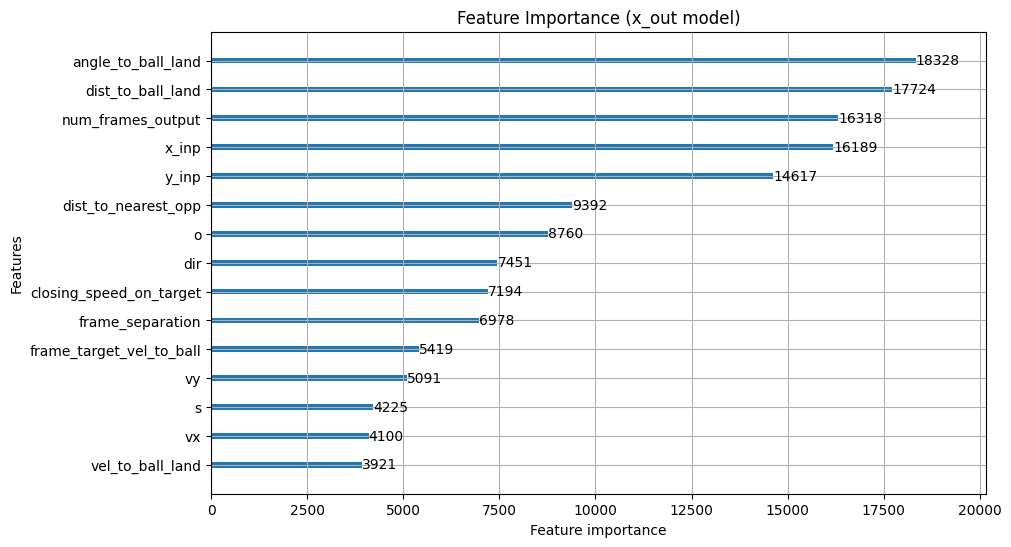

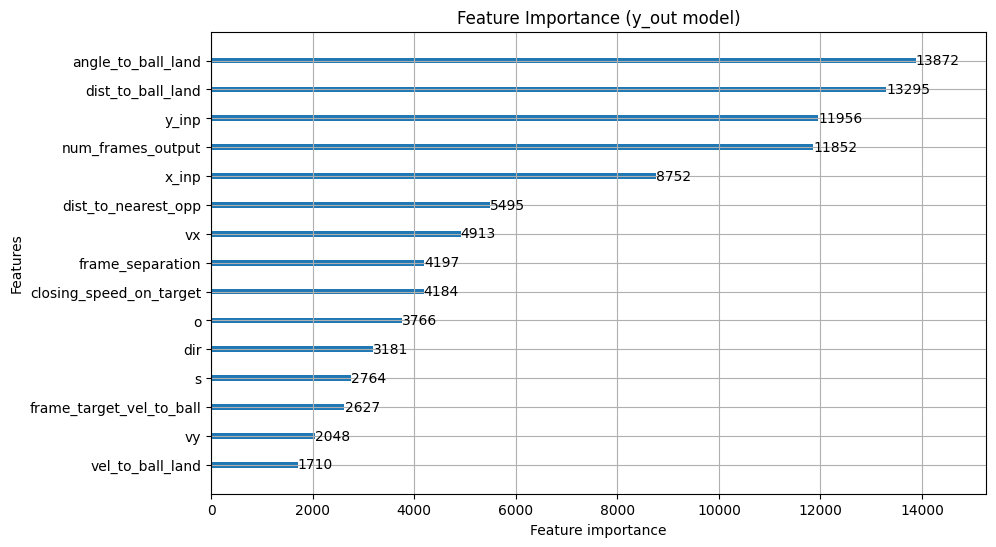

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance for the x_model
lgb.plot_importance(model_x, max_num_features=15, title="Feature Importance (x_out model)", figsize=(10, 6))
plt.show()

# Plot feature importance for the y_model
lgb.plot_importance(model_y, max_num_features=15, title="Feature Importance (y_out model)", figsize=(10, 6))
plt.show()

### Plot the Trajectory

No plot found at /content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/prediction_comparison_LGBM_lr0_02_n4000_nl40.png. Creating it now...
Plot saved locally to: prediction_comparison_LGBM_lr0_02_n4000_nl40.png
Copying new plot to Google Drive...
New plot created, saved, and copied. ✅


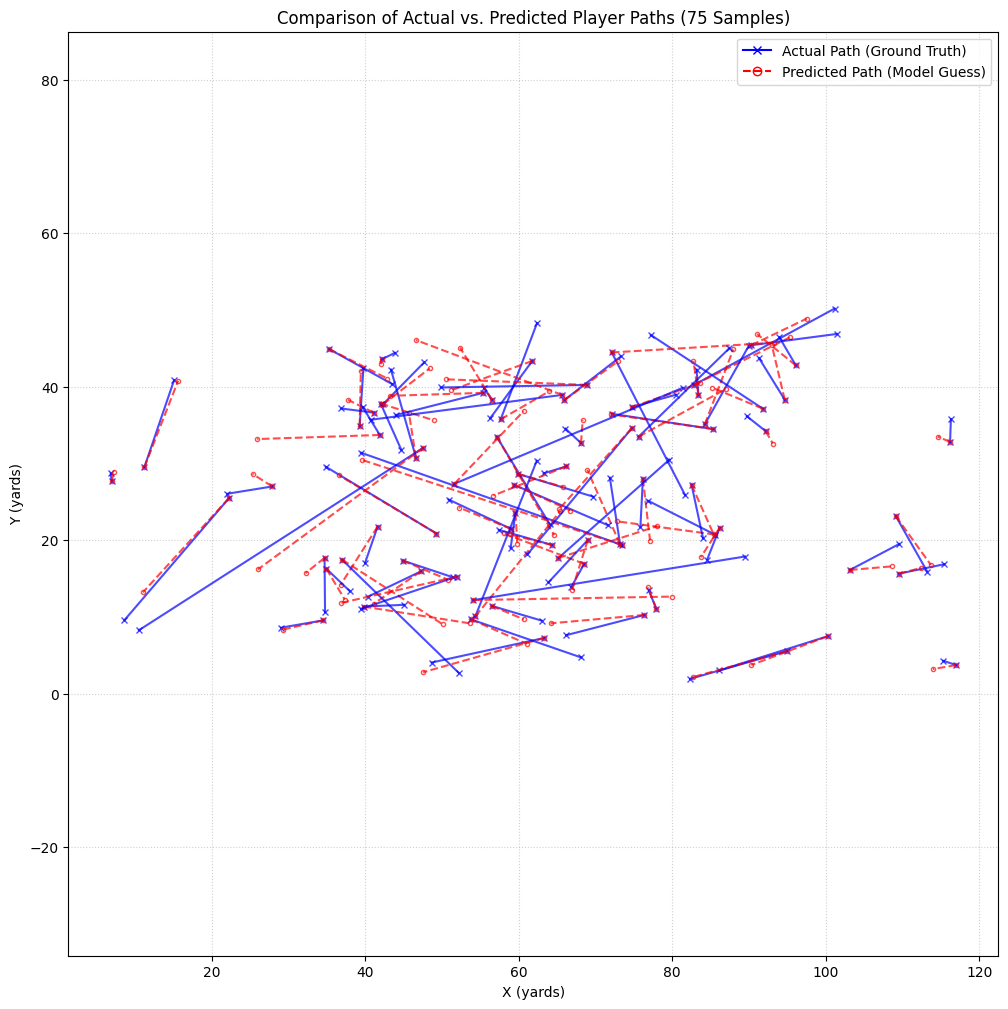

In [ ]:
from matplotlib.lines import Line2D
from IPython.display import Image, display

# --- Define paths for plot ---
# Use the 'model_id_string' variable from the training cell
if 'model_id_string' not in locals():
    print("Warning: 'model_id_string' not found. Using default filename.")
    print("Please re-run the training cell to set hyperparameters.")
    model_id_string = "default_model"

plot_filename = f"prediction_comparison_{model_id_string}.png"
local_plot_path = plot_filename
drive_plot_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/{plot_filename}"

if os.path.exists(drive_plot_path):
    print(f"Found existing plot on Google Drive: {os.path.basename(drive_plot_path)}. Loading...")

    !cp "{drive_plot_path}" {local_plot_path}

    print("Displaying existing plot. ✅")
    display(Image(filename=local_plot_path))

else:
    # If file doesn't exist, create it ---
    print(f"No plot found at {drive_plot_path}. Creating it now...")

    # --- Combine all the data into a single DataFrame ---
    plot_df = X_val.reset_index(drop=True).copy()
    y_val_reset = y_val.reset_index(drop=True)

    plot_df['x_out'] = y_val_reset['x_out']
    plot_df['y_out'] = y_val_reset['y_out']

    plot_df['x_pred'] = x_pred_lgbm
    plot_df['y_pred'] = y_pred_lgbm

    # --- Select a random sample of players to plot ---
    N_SAMPLES = 75
    sample_df = plot_df.sample(N_SAMPLES, random_state=1337)

    # --- Create the plot ---
    plt.figure(figsize=(12, 12))

    # --- Draw two lines for each player in the sample ---
    for _, row in sample_df.iterrows():
        start_x, start_y = row['x_inp'], row['y_inp']
        actual_x, actual_y = row['x_out'], row['y_out']
        pred_x, pred_y = row['x_pred'], row['y_pred']

        plt.plot([start_x, actual_x], [start_y, actual_y],
                 color='blue', alpha=0.7, linestyle='-', marker='x', markersize=5)

        plt.plot([start_x, pred_x], [start_y, pred_y],
                 color='red', alpha=0.7, linestyle='--', marker='o', markersize=3, mfc='none')

    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='-', marker='x', label='Actual Path (Ground Truth)'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', mfc='none', label='Predicted Path (Model Guess)')
    ]

    # --- Plot and save the plot ---
    plt.title(f'Comparison of Actual vs. Predicted Player Paths ({N_SAMPLES} Samples)')
    plt.xlabel('X (yards)')
    plt.ylabel('Y (yards)')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')

    # Save the plot to the local path
    plt.savefig(local_plot_path, bbox_inches='tight')

    # Close the plot to prevent it from displaying twice
    plt.close()
    print(f"Plot saved locally to: {local_plot_path}")

    drive_plot_dir = os.path.dirname(drive_plot_path)
    !mkdir -p "{drive_plot_dir}"

    print("Copying new plot to Google Drive...")
    !cp {local_plot_path} "{drive_plot_path}"
    print(f"New plot created, saved, and copied. ✅")

    # --- Display the newly created plot ---
    display(Image(filename=local_plot_path))

# Error Analysis

In [ ]:
# Find the worst 100 predictions in validation set, see what they all have in common.

--- ERROR ANALYSIS ---

--- Top 15 Worst Predictions (Raw Data) ---
             x_inp      y_inp     s     a         dir           o        vx  \
168466   40.869999  36.410000  3.23  1.21  352.609985  271.809998  3.203170   
168465   40.869999  36.410000  3.23  1.21  352.609985  271.809998  3.203170   
168493   40.830002  36.709999  3.12  0.76  351.899994  260.890015  3.088874   
177673   34.160000  32.500000  3.02  1.82  342.459991   43.840000  2.879591   
168464   40.869999  36.410000  3.23  1.21  352.609985  271.809998  3.203170   
1729656  61.410000  19.190001  1.04  1.89  169.979996  260.019989 -1.024137   
168492   40.830002  36.709999  3.12  0.76  351.899994  260.890015  3.088874   
1729635  61.389999  19.299999  1.24  1.79  178.550003  260.019989 -1.239603   
168463   40.869999  36.410000  3.23  1.21  352.609985  271.809998  3.203170   
168439   40.910000  36.090000  3.19  1.62  355.459991  278.950012  3.179991   
168491   40.830002  36.709999  3.12  0.76  351.899994  260.8900

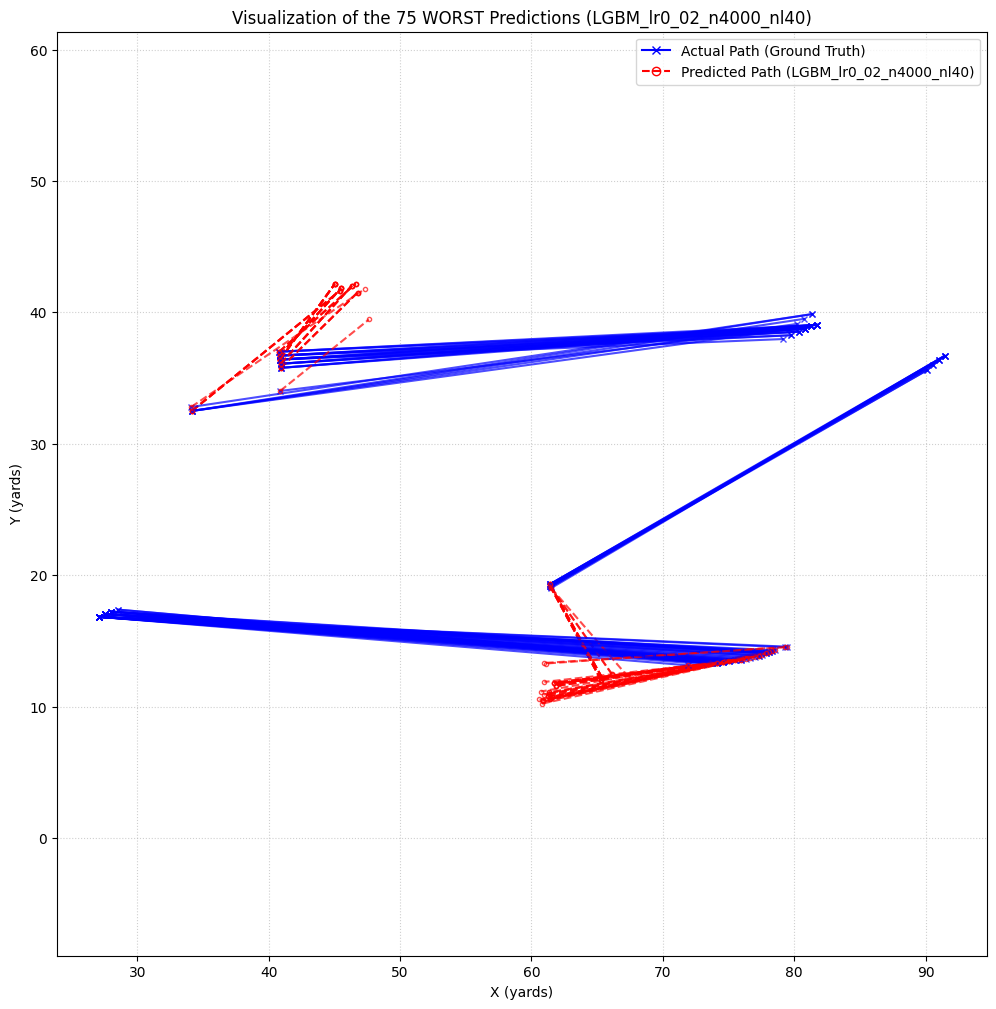

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from IPython.display import Image, display

# --- NUMERICAL ERROR ANALYSIS ---

print("--- ERROR ANALYSIS ---")

# Get the validation set's features and true values
analysis_df = X_val.reset_index(drop=True).copy()
y_val_reset = y_val.reset_index(drop=True)

# Add the true values and the model's predictions
analysis_df['x_out'] = y_val_reset['x_out']
analysis_df['y_out'] = y_val_reset['y_out']
analysis_df['x_pred'] = x_pred_lgbm
analysis_df['y_pred'] = y_pred_lgbm

# Calculate the 'error_yards' (Euclidean distance)
analysis_df['error_yards'] = np.sqrt(
    (analysis_df['x_pred'] - analysis_df['x_out'])**2 +
    (analysis_df['y_pred'] - analysis_df['y_out'])**2
)

# Sort by the error to find the worst predictions
worst_preds_df = analysis_df.sort_values('error_yards', ascending=False)

print("\n--- Top 15 Worst Predictions (Raw Data) ---")
# Look at these rows. Is there a pattern?
print(worst_preds_df.head(15))

print("\n--- Feature Averages (Worst 100 vs. All) ---")
# Compare the worst 100 to the validation set's average
worst_100_stats = worst_preds_df.head(100)[feature_cols].mean()
all_val_stats = analysis_df[feature_cols].mean()

# Combine them for easy comparison
stats_comparison = pd.DataFrame({
    'Worst 100 Avg': worst_100_stats,
    'All Val Avg': all_val_stats,
})
stats_comparison['Difference (Percent)'] = 100 * (stats_comparison['Worst 100 Avg'] - stats_comparison['All Val Avg']) / stats_comparison['All Val Avg']

# Display features with the biggest difference
print(stats_comparison.sort_values('Difference (Percent)', ascending=False).head(10))
print("\n" + "="*50 + "\n") # Separator


# --- VISUAL ERROR ANALYSIS ---

# Define paths for the plot
if 'model_id_string' not in locals():
    print("Warning: 'model_id_string' not found. Using default filename.")
    model_id_string = "default_model"

plot_filename = f"worst_predictions_{model_id_string}.png"
local_plot_path = plot_filename
drive_plot_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/{plot_filename}"

if os.path.exists(drive_plot_path):
    print(f"Found existing plot on Google Drive: {os.path.basename(drive_plot_path)}. Loading...")
    !cp "{drive_plot_path}" {local_plot_path}
    print("Displaying existing plot. ✅")
    display(Image(filename=local_plot_path))

else:
    print(f"No plot found at {drive_plot_path}. Creating it now...")

    # Get the 75 worst predictions for plotting
    N_SAMPLES = 75
    sample_df = worst_preds_df.head(N_SAMPLES)

    # Create the plot
    plt.figure(figsize=(12, 12))
    for _, row in sample_df.iterrows():
        start_x, start_y = row['x_inp'], row['y_inp']
        actual_x, actual_y = row['x_out'], row['y_out']
        pred_x, pred_y = row['x_pred'], row['y_pred']

        plt.plot([start_x, actual_x], [start_y, actual_y],
                 color='blue', alpha=0.7, linestyle='-', marker='x', markersize=5)
        plt.plot([start_x, pred_x], [start_y, pred_y],
                 color='red', alpha=0.7, linestyle='--', marker='o', markersize=3, mfc='none')

    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='-', marker='x', label='Actual Path (Ground Truth)'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', mfc='none', label=f'Predicted Path ({model_id_string})')
    ]

    plt.title(f'Visualization of the 75 WORST Predictions ({model_id_string})')
    plt.xlabel('X (yards)')
    plt.ylabel('Y (yards)')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')

    plt.savefig(local_plot_path, bbox_inches='tight')
    plt.close()
    print(f"Plot saved locally to: {local_plot_path}")

    # Create directory and copy to Drive
    drive_plot_dir = os.path.dirname(drive_plot_path)
    !mkdir -p "{drive_plot_dir}"
    print(f"Copying new plot to {drive_plot_path}...")
    !cp {local_plot_path} "{drive_plot_path}"
    print(f"New plot created, saved, and copied. ✅")

    # Display the newly created plot
    display(Image(filename=local_plot_path))

### Summary

Based on the feature averages (worst 100 vs. all), there are massive differences on:

*   closing_speed_on_target: +4139%. The worst predictions occur when the receiver is sprinting towards the ball at an exceptionally high speed (avg. 2.38) compared to a normal play (avg. 0.09).
*   frame_target_vel_to_ball: +2382%. This means a defender is also sprinting at a high relative velocity, trying to close the gap on the fast receiver.
*   vel_to_ball_land: +1986%. On a normal play, vel_to_ball_land is 0.07. On the plays with worst predictions, the average is 1.63. This extreme, high-speed movement signals that it is likely due to a long pass.

Therefore, deep passes where both the receiver and defender are in a full sprint are cases where the predictions fail.

In addition:

*   is_defense: +30.6%. It is 30% more likely to fail when predicting a defender, who reacts to the play unpredictably.
*   num_frames_output: +53.4%. The model fails on plays that take a long time to develop (avg. 23 frames vs. the normal 15). This confirms the "long pass" idea. The longer the time, the more a player's simple starting velocity (vx, vy) becomes useless, and the more they have to react.
*   dist_to_ball_land: +70.8%. The model fails when players start far away from the ball's landing spot.

Overall, the model is good at predicting average or planned offensive routes. It completely fails when it needs to predict a high-speed, long-distance defensive reaction.



# Push Codes to GitHUb

### Set Up Git and Clone Repo

In [2]:
USERNAME = "ellydo17"

# The name of your new, empty GitHub repo
REPO_NAME = "nfl-big-data-bowl-2026-ma-797"

from google.colab import userdata
try:
    GH_TOKEN = userdata.get('GH_TOKEN')
except KeyError:
    raise Exception("No 'GH_TOKEN' found.")

# Ssets up the authentication with the token
!git config --global user.name "{USERNAME}"
!git config --global user.email "{USERNAME}@users.noreply.github.com"
repo_url = f"https://{GH_TOKEN}@github.com/{USERNAME}/{REPO_NAME}.git"

# Creates a new folder in Colab named {REPO_NAME}
!git clone {repo_url}

Cloning into 'nfl-big-data-bowl-2026-ma-797'...


In [3]:
%%writefile /content/{REPO_NAME}/.gitignore
*.parquet
*.csv
Models/
*.txt
.ipynb_checkpoints/
__pycache__/

Writing /content/nfl-big-data-bowl-2026-ma-797/.gitignore


In [ ]:
import os

source_notebook = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl_big_data_bowl_2026_stronger_model.ipynb"
source_figures = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures"

print("Copying files from Drive to Git folder...")

!cp "{source_notebook}" /content/{REPO_NAME}/

if os.path.exists(source_figures):
    !cp -r "{source_figures}" /content/{REPO_NAME}/
else:
    print("Warning: Figures folder not found in Drive path.")


%cd /content/{REPO_NAME}
!git add .
!git commit -m "Initial commit with notebook and figures"
!git push origin main
print("\n✅ Success! Files pushed to GitHub.")